In [1]:
from nuplan.planning.utils.multithreading.worker_parallel import SingleMachineParallelExecutor
from nuplan.planning.scenario_builder.scenario_filter import ScenarioFilter
from nuplan.planning.scenario_builder.nuplan_db.nuplan_scenario_builder import NuPlanScenarioBuilder
from nuplan.planning.scenario_builder.nuplan_db.nuplan_scenario_utils import ScenarioMapping
from GameFormer.train_utils import *
from common_utils import *
from GameFormer.data_utils import *

data_path = '/data/fyy/GameFormer-Planner/nuplan/dataset/nuplan-v1.1/splits/mini'
map_path = '/data/fyy/GameFormer-Planner/nuplan/dataset/maps'
model_path = 'training_log/Exp_e40_dual/model_epoch_60_valADE_1.2866.pth'
map_version = "nuplan-maps-v1.0"
scenarios_per_type = 1000
total_scenarios = None
shuffle_scenarios = False
sensor_root = None
db_files = None

scenario_mapping = ScenarioMapping(scenario_map=get_scenario_map(), subsample_ratio_override=0.5)
builder = NuPlanScenarioBuilder(data_path, map_path, sensor_root, db_files, map_version, scenario_mapping=scenario_mapping)

scenario_filter = ScenarioFilter(*get_filter_parameters(scenarios_per_type, total_scenarios, shuffle_scenarios))
worker = SingleMachineParallelExecutor(use_process_pool=True)
scenarios = builder.get_scenarios(scenario_filter, worker) 

In [66]:
idx = 69

In [67]:
from Planner.planner import Planner
from nuplan.planning.simulation.simulation import Simulation
from nuplan.planning.simulation.simulation_setup import SimulationSetup
import datetime
from nuplan.planning.simulation.callback.simulation_log_callback import SimulationLogCallback
from nuplan.planning.simulation.callback.metric_callback import MetricCallback
from nuplan.planning.simulation.callback.multi_callback import MultiCallback
from tqdm import tqdm
from nuplan.planning.simulation.controller.log_playback import LogPlaybackController
from nuplan.planning.simulation.controller.two_stage_controller import TwoStageController
from nuplan.planning.simulation.controller.tracker.lqr import LQRTracker
from nuplan.planning.simulation.controller.motion_model.kinematic_bicycle import KinematicBicycleModel
from nuplan.planning.simulation.observation.tracks_observation import TracksObservation
from nuplan.planning.simulation.observation.idm_agents import IDMAgents
from nuplan.planning.simulation.simulation_time_controller.step_simulation_time_controller import StepSimulationTimeController

experiment_name = 'open_loop_boxes'
job_name = 'gameformer_planner'
experiment_time = datetime.datetime.now()
experiment = f"{experiment_name}/{job_name}/{experiment_time}"  
output_dir = f"testing_log/{experiment}"
simulation_dir = "simulation"
metric_dir = "metrics"
aggregator_metric_dir = "aggregator_metric"
metric_engine = build_metrics_engine('open_loop_boxes', output_dir, metric_dir)
planner = Planner(model_path, 'cuda')

# Iterate through scenarios
# for scenario in tqdm(scenarios, desc='Running simulation'):

scenario = scenarios[idx]
tracker = LQRTracker(q_longitudinal=[10.0], r_longitudinal=[1.0], q_lateral=[1.0, 10.0, 0.0], 
                    r_lateral=[1.0], discretization_time=0.1, tracking_horizon=10, 
                    jerk_penalty=1e-4, curvature_rate_penalty=1e-2, 
                    stopping_proportional_gain=0.5, stopping_velocity=0.2)
motion_model = KinematicBicycleModel(get_pacifica_parameters())

# Ego Controller and Perception
if experiment == 'open_loop_boxes':
    ego_controller = LogPlaybackController(scenario) 
    observations = TracksObservation(scenario)
elif experiment == 'closed_loop_nonreactive_agents': 
    ego_controller = TwoStageController(scenario, tracker, motion_model)
    observations = TracksObservation(scenario)
else:      
    ego_controller = TwoStageController(scenario, tracker, motion_model)
    observations = IDMAgents(target_velocity=10, min_gap_to_lead_agent=1.0, headway_time=1.5,
                                accel_max=1.0, decel_max=2.0, scenario=scenario,
                                open_loop_detections_types=["PEDESTRIAN", "BARRIER", "CZONE_SIGN", 
                                                            "TRAFFIC_CONE", "GENERIC_OBJECT"])

# Simulation Manager
simulation_time_controller = StepSimulationTimeController(scenario)

# Stateful callbacks
metric_callback = MetricCallback(metric_engine=metric_engine)
sim_log_callback = SimulationLogCallback(output_dir, simulation_dir, "msgpack")

# Construct simulation and manager
simulation_setup = SimulationSetup(
    time_controller=simulation_time_controller,
    observations=observations,
    ego_controller=ego_controller,
    scenario=scenario,
)

simulation = Simulation(
    simulation_setup=simulation_setup,
    callback=MultiCallback([metric_callback, sim_log_callback])
)

simulation.callback.on_simulation_start(simulation.setup)

simulation.callback.on_initialization_start(simulation.setup, planner)

# Initialize Planner
planner.initialize(simulation.initialize())

# Execute specific callback
simulation.callback.on_initialization_end(simulation.setup, planner)

while simulation.is_simulation_running():
    simulation.callback.on_step_start(simulation.setup, planner)
    planner_input = simulation.get_planner_input()
    simulation.callback.on_planner_start(simulation.setup, planner)
    break


In [68]:
from Planner.planner_utils import *
from Planner.observation import *

# trajectory = planner.compute_trajectory(planner_input)
current_input = planner_input
history = current_input.history
traffic_light_data = list(current_input.traffic_light_data)
ego_state, observation = history.current_state

features = observation_adapter(history, traffic_light_data, planner._map_api, planner._route_roadblock_ids, planner._device)
trajectory = planner._plan(ego_state, history, traffic_light_data, observation)
reference_path = planner._get_reference_path(ego_state, traffic_light_data, observation)
with torch.no_grad():
    plan_init, predictions, scores, ego_state_transformed, neighbors_state_transformed = planner._get_prediction(features)
    plan = planner._trajectory_planner.plan(ego_state, ego_state_transformed, neighbors_state_transformed, predictions, plan_init, scores, reference_path, observation)
# plan, predictions, scores, ego_state_transformed, neighbors_state_transformed = planner._get_prediction(features)


/data/fyy/anaconda3/envs/nuplan/lib/python3.9/site-packages/torch/nn/modules/transformer.py:562: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._transformer_encoder_layer_fwd(
/data/fyy/anaconda3/envs/nuplan/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(
/data/fyy/anaconda3/envs/nuplan/lib/python3.9/site-packages/torch/_functorch/deprecated.py:80: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a fut

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.transforms as mpl_transforms
from common_utils import *
from GameFormer.data_utils import *

sns.set(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP']
def create_map_raster(lanes, crosswalks, route_lanes):
    added_label_for_lane = False
    added_label_for_crosswalk = False
    
    for i in range(lanes.shape[0]):
        lane = lanes[i]
        if lane[0][0] != 0:
            if not added_label_for_lane:
                # plt.scatter(lane[:, 0], lane[:, 1], c='gray', marker='x', zorder=10, s=15, alpha=0.8, label='周围车道')
                plt.plot(lane[:, 0], lane[:, 1], c='#cccccc', linewidth=12, alpha = 1, zorder= 10) 
                added_label_for_lane = True
            else:
                # plt.scatter(lane[:, 0], lane[:, 1], c='gray', marker='x', zorder=10, s=15, alpha=0.8)
                plt.plot(lane[:, 0], lane[:, 1], c='#cccccc', zorder= 10, alpha = 1, linewidth=12) 
 
    for j in range(crosswalks.shape[0]):
        crosswalk = crosswalks[j]
        if crosswalk[0][0] != 0:
            if not added_label_for_crosswalk:
                plt.plot(crosswalk[:, 0], crosswalk[:, 1], 'b', linewidth=4, zorder= 11, label='人行横道')  # 为人行横道添加图例标签
                added_label_for_crosswalk = True
            else:
                plt.plot(crosswalk[:, 0], crosswalk[:, 1], 'b', zorder= 11, linewidth=4)


def draw_rectangles_along_path(points, width):
    length = 10
    overlap = 1  # 重叠的比例
    for i in range(0, len(points) - length, length):
        segment = points[i : i + length]
        # 计算方向向量 
        direction = segment[-1] - segment[0]
        direction_norm = np.linalg.norm(direction)
        if direction_norm == 0:
            continue
        direction_unit = direction / direction_norm
        
        # 计算垂直向量
        perpendicular = np.array([-direction_unit[1], direction_unit[0]]) * (width / 2)
        
        # 计算矩形的四个角点，稍微扩展每个矩形以避免空隙
        p1 = segment[0] - perpendicular - direction_unit * overlap
        p2 = segment[0] + perpendicular - direction_unit * overlap
        p3 = segment[-1] + perpendicular + direction_unit * overlap
        p4 = segment[-1] - perpendicular + direction_unit * overlap
        
        # 绘制矩形，包括边框
        plt.fill([p1[0], p2[0], p3[0], p4[0]], [p1[1], p2[1], p3[1], p4[1]], '#dddddd', edgecolor='#dddddd', linewidth=1)
   
      
def create_map_raster(lanes):
    lane_width = 3.5  # 假设车道宽度为3.5米的一半
    lanes = lanes[:, :, :2].reshape(-1, 2)
    print(lanes.shape)
    draw_rectangles_along_path(lanes, 3)
    # draw_continuous_rectangles_along_path(lanes, 3)
    
    # for i in range(lanes.shape[0]):
    #     lane = lanes[i]
    #     if lane[0][0] != 0:
    #         for k in range(len(lane) - 1):
    #             # 计算每段中心线的方向向量
    #             segment_vector = lane[k+1] - lane[k]
    #             # 计算垂直向量
    #             perpendicular_vector = np.array([-segment_vector[1], segment_vector[0]])
    #             perpendicular_vector = perpendicular_vector / np.linalg.norm(perpendicular_vector) * lane_width

    #             # 计算矩形的四个角点
    #             # print(lane[k].shape)
    #             p1 = lane[k] + perpendicular_vector
    #             p2 = lane[k] - perpendicular_vector
    #             p3 = lane[k+1] - perpendicular_vector
    #             p4 = lane[k+1] + perpendicular_vector

    #             if not added_label_for_lane:
    #                 plt.fill([p1[0], p2[0], p3[0], p4[0]], [p1[1], p2[1], p3[1], p4[1]], 'gray', alpha=0.5, label='周围车道')
    #                 added_label_for_lane = True
    #             else:
    #                 plt.fill([p1[0], p2[0], p3[0], p4[0]], [p1[1], p2[1], p3[1], p4[1]], 'gray', alpha=0.5)

    # for j in range(crosswalks.shape[0]):
    #     crosswalk = crosswalks[j]
    #     if crosswalk[0][0] != 0:
    #         if not added_label_for_crosswalk:
    #             plt.plot(crosswalk[:, 0], crosswalk[:, 1], 'b', linewidth=4, zorder=11, label='人行横道')
    #             added_label_for_crosswalk = True
    #         else:
    #             plt.plot(crosswalk[:, 0], crosswalk[:, 1], 'b', zorder=11, linewidth=4)

    # plt.legend()
    
    
def create_ego_raster(vehicle_state):
    # 提取自车参数
    vehicle_parameters = get_pacifica_parameters()
    ego_width = vehicle_parameters.width
    ego_front_length = vehicle_parameters.front_length
    ego_rear_length = vehicle_parameters.rear_length

    # 提取自车状态
    x_center, y_center, heading = vehicle_state[0], vehicle_state[1], vehicle_state[2]
    ego_bottom_right = (x_center - ego_rear_length, y_center - ego_width / 2)

    # 绘制矩形以代表自车，并只为自车添加一次标签（使用label参数，但不写字）
    rect = plt.Rectangle(ego_bottom_right, ego_front_length + ego_rear_length, ego_width, linewidth=2, color='r', alpha=0.6, zorder=20, label='自车',
                         transform=mpl_transforms.Affine2D().rotate_around(x_center, y_center, heading) + plt.gca().transData)
    plt.gca().add_patch(rect)

def create_agents_raster(agents):
    # 标志变量，用于控制标签的添加
    added_label_for_agents = False    

    for i in range(agents.shape[0]):
        if agents[i, 0] != 0:
            x_center, y_center, heading = agents[i, 0], agents[i, 1], agents[i, 2]
            agent_length, agent_width = agents[i, 6], agents[i, 7]
            agent_bottom_right = (x_center - agent_length/2, y_center - agent_width/2)

            # 为第一个代理车辆添加标签，之后的代理车辆不再添加
            if not added_label_for_agents:
                rect = plt.Rectangle(agent_bottom_right, agent_length, agent_width, linewidth=2, color='m', alpha=0.6, zorder=17, label='其他交通参与者',
                                     transform=mpl_transforms.Affine2D().rotate_around(*(x_center, y_center), heading) + plt.gca().transData)
                added_label_for_agents = True
            else:
                rect = plt.Rectangle(agent_bottom_right, agent_length, agent_width, linewidth=2, color='m', alpha=0.6, zorder=17,
                                     transform=mpl_transforms.Affine2D().rotate_around(*(x_center, y_center), heading) + plt.gca().transData)
            
            plt.gca().add_patch(rect)
         
def draw_obs_trajectory(ego_trajectory, agent_trajectories, color_ego, color_others, label):
    flag = True
    # plot ego 
    plt.plot(ego_trajectory[:, 0], ego_trajectory[:, 1], alpha=0.8, color=color_ego, linewidth=3, marker='.', zorder=16, label="自车"+label)
    # plot others
    for i in range(agent_trajectories.shape[0]):
        if agent_trajectories[i, -1, 0] != 0:
            trajectory = agent_trajectories[i]
            if flag:
                plt.plot(trajectory[:, 0], trajectory[:, 1], alpha=0.8, color=color_others, linewidth=3, marker='.', zorder=15, label="其他交通参与者"+label)
                flag = False
            plt.plot(trajectory[:, 0], trajectory[:, 1], alpha=0.8, color=color_others, linewidth=3, marker='.', zorder=15)
       
def draw_ref_trajectory(ego_trajectory):
    # plot ego 
    plt.plot(ego_trajectory[:, 0], ego_trajectory[:, 1], alpha=0.8, color='pink', linewidth=3, marker='.', zorder=16, label='参考路径')

def draw_plan2_trajectory(ego_trajectory):
    # plot ego 
    plt.plot(ego_trajectory[:, 0], ego_trajectory[:, 1], alpha=0.8, color='orange', linewidth=3, marker='.', zorder=19, label='修正规划轨迹')
      
def draw_pred_trajectory(ego_trajectory, agent_trajectories, color_ego, color_others, label):
    flag = True
    # plot ego 
    plt.plot(ego_trajectory[:, 0], ego_trajectory[:, 1], alpha=0.8, color=color_ego, linewidth=3, marker='.', zorder=20, label="初始规划轨迹")
    # plt.plot(ego_trajectory[-1, 0], ego_trajectory[-1, 1], marker='o', color=color_ego, markersize=12, alpha=0.75, zorder=30, label=label)

    # plot others
    for i in range(agent_trajectories.shape[0]):
        if agent_trajectories[i, -1, 0] != 0:
            trajectory = agent_trajectories[i]
            if flag:
                plt.plot(trajectory[:, 0], trajectory[:, 1], alpha=0.8, color=color_others, linewidth=3, marker='.', zorder=15, label="周车预测轨迹")
                flag = False
            plt.plot(trajectory[:, 0], trajectory[:, 1], alpha=0.8, color=color_others, linewidth=3, marker='.', zorder=15)

from scipy.signal import savgol_filter
def smooth_trajectory_savgol(trajectory, window_size=5, poly_order=2):
    if window_size % 2 == 0:
        raise ValueError("窗口大小必须是奇数")
    
    trajectory_array = np.array(trajectory)
    x_smooth = savgol_filter(trajectory_array[:, 0], window_size, poly_order)
    y_smooth = savgol_filter(trajectory_array[:, 1], window_size, poly_order)
    
    return np.column_stack((x_smooth, y_smooth))
      

torch.Size([2000, 2])


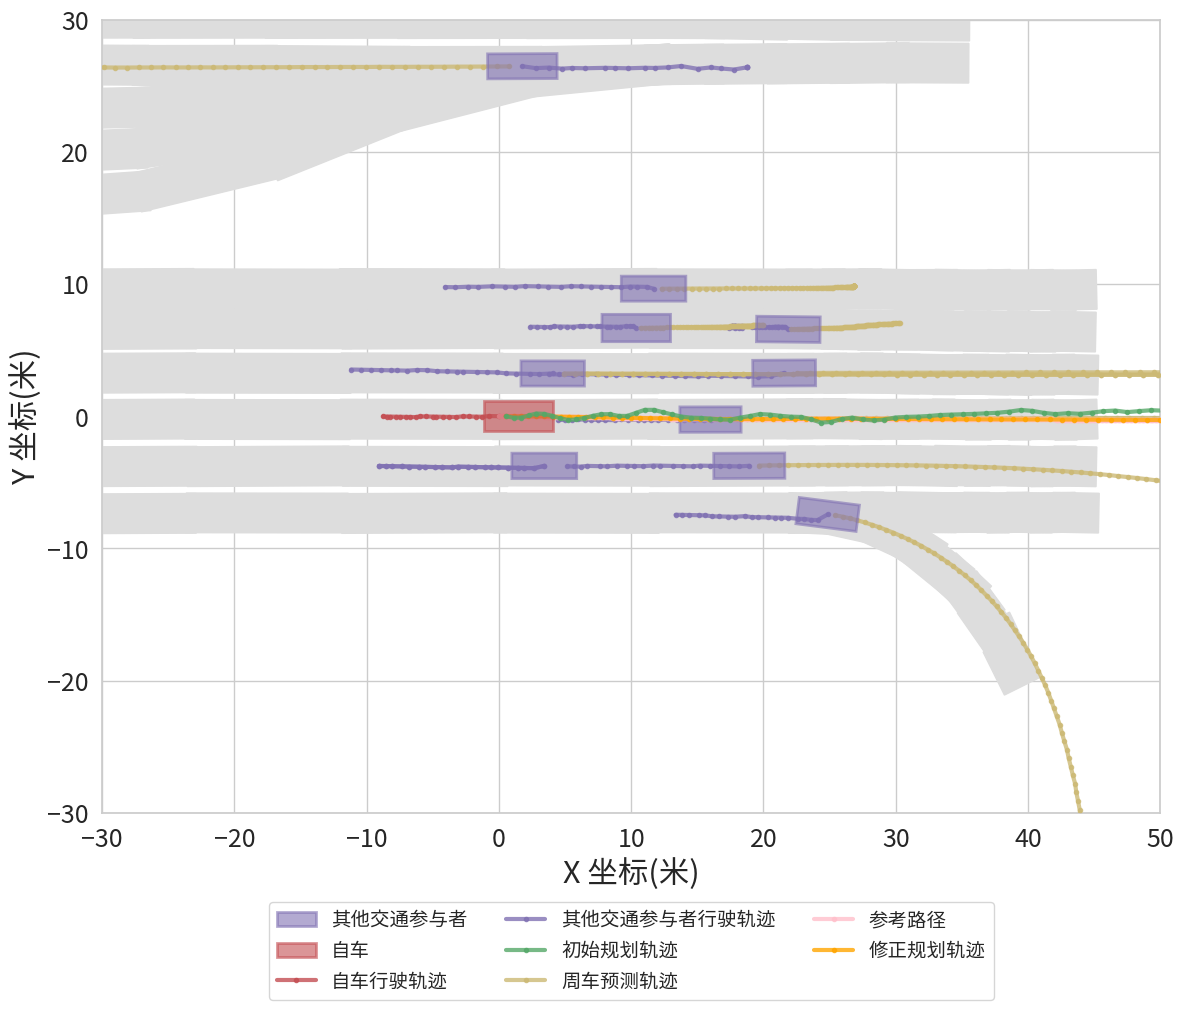

In [70]:
# plt.figure(figsize=(8, 8))
plt.figure(figsize=(12, 12))
plt.xlim(-30, 50) 
plt.ylim(-30, 30) 
# plt.gca().set_facecolor('black')
ego_agent_past = features['ego_agent_past'][0].cpu()
neighbor_agents_past = features['neighbor_agents_past'][0].cpu()
lanes = features['map_lanes'][0].cpu()

ego_future = predictions[0, 0, 0, :, :2]
neighbors_future = predictions[0, 1:, 0, :, :2]
# neighbors_future_valid = torch.ne(neighbors_future[..., :2], 0)[idx]


create_map_raster(lanes[:, :, :2])
create_agents_raster(neighbor_agents_past[:, -1])
create_ego_raster(ego_agent_past[-1])

# Draw past and future trajectories
draw_obs_trajectory(ego_agent_past, neighbor_agents_past, 'r', 'm', '行驶轨迹')
draw_pred_trajectory(smooth_trajectory_savgol(plan_init[0][:, :2].detach().cpu().numpy()), neighbors_future.detach().cpu().numpy(), 'g', 'y', '预测轨迹')
draw_ref_trajectory(reference_path[:, :2])
draw_plan2_trajectory(plan[:, :2])

plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('X 坐标(米)', fontsize=22)
plt.ylabel('Y 坐标(米)', fontsize=22)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fontsize=14, ncol=3)

# plt.legend(fontsize=18)
# plt.grid(False)
# plt.axis('off')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig(f'fig/plan/plan_{idx}.pdf')
# plt.savefig("fig/pred/pred_label.pdf")